# ESA - Collision Avoidance Challenge

## Introduction

As space debris becomes an increasingly pressing issue, the European Space Agency (ESA) initiated the "Collision Avoidance Challenge" in 2019 to tackle potential collisions in orbit through data analysis and artificial intelligence. This notebook delves into this endeavor, seeking to replicate the strategies of the leading teams and the post-competition advancements made by the ESA itself.

Join us in this analytical journey to explore how data science and artificial intelligence could help enhance the safety of our orbital environment!

For an in-depth look at the competition and its aims, please refer to the official competition website listed below, and check out the ESA's post-competition publication *"Spacecraft Collision Avoidance Challenge: Design and Results of a Machine Learning Competition"* available in this project's repository (***article.pdf***) :
- https://kelvins.esa.int/collision-avoidance-challenge/home/


**Disclaimer**: The content and implementations in this project reflect my interpretation of the methods described in the article. As such, they may not mirror the exact procedures of the participating teams and could contain inaccuracies.

## Setup

We start by importing the necessary libraries for this project. All the dependencies required are listed in the ***requirements.txt*** file.

In [ ]:
pip install -r requirements.txt

In [2]:
import pandas as pd
import warnings
from itertools import combinations

from sklearn.metrics import fbeta_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMRegressor
import torch
import magpies

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.options.mode.copy_on_write = True
warnings.simplefilter(action='ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We then load the competition data into our environment, which can be retrieved directly from the following link:

- https://zenodo.org/records/4463683

Here, we aim to replicate the conditions of the competitors. Therefore, we use only the data contained in the ***kelvins_competition_data*** folder.

In [3]:
df_train_init = pd.read_csv(".\\data\\train_data.csv").sort_values(by=['event_id', 'time_to_tca'], ascending=[True, False])
X_test_init = pd.read_csv(".\\data\\test_data.csv").sort_values(by=['event_id', 'time_to_tca'], ascending=[True, False])
y_test_init = pd.read_csv(".\\data\\test_data_private.csv").sort_values(by=['event_id'])

## Metrics

Now, we define the metrics used in the competition, which will be the basis for replicating the results. Here are the formulas for these metrics:

The loss used in the competition is defined from two error metrics as follows, where $r$ corresponds to the final risk and $\hat{r}$ to the associated prediction:

$$\boxed{L(\hat{r}) = \frac{1}{F_2} MSE_{hr}(r, \hat{r})}$$

We then have:

$$MSE_{HR}(r, \hat{r}) = \frac{1}{N^*} \sum_{i=1}^N I_i(r_i - \hat{r}_i)^2$$

- $I_i = \begin{cases} 
1 & \text{if } r_i \geq -6, \\
0 & \text{else}.
\end{cases}$ , indicating whether the data belongs to the high-risk group $(1)$ or a low-risk group $(0)$
- $N^* = \sum_{i=1}^N I_i$ , representing the number of high-risk data points


And:

$$F_{\beta} = (1 + \beta^2) \frac{p \times q}{(\beta^2 \times p) + q}$$

- $p$ and $q$ corresponding respectively to precision and recall in binary classification, with our classes defined by $I$.

In summary, $MSE_{HR}$ represents an average distance calculated between predicted and real data, but only for the real high-risk data $(r \geq -6)$. $F_{\beta}$, on the other hand, represents a performance score in the classification of low and high-risk data, where the balance between precision and recall is adjusted according to the $\beta$ parameter: the larger $\beta$ is, the greater the weight of recall, and vice versa.

From these metrics, two essential points are to be noted:
- Since $MSE_{HR}$ is calculated only on the actual high-risk data, it will be in our interest to clip the value of data predicted as low risk by our models. This will have the effect of minimizing the $MSE_{HR}$, without impacting our $F_2$ score.
- We consider here the $F_2$ score, which therefore places more weight on false negatives than on false positives. It might then be interesting to bias the model to predict high-risk data more often, even when this is not the case, to limit false positives as much as possible.


In [4]:
def mse_hr(y_true, y_pred, clipped_value=-6.001):
    """
    Compute MSE_hr loss defined previously
    Integrate the clipping of low risk prediction.

    Parameters:
    - y_true (numpy array): ground truth (correct) target values.
    - y_pred (numpy array): estimated target values
    - clipped_value (float): value to clip predictions which are not predicted as high risk

    Returns:
    - error (float): the best value is 0.0
    """
    risk_category_true = np.where(y_true >= -6.00, 1, 0)
    y_true = y_true[risk_category_true == 1]
    y_pred = y_pred[risk_category_true == 1]

    y_pred_clipped = np.where(y_pred >= -6, y_pred, clipped_value)

    return mean_squared_error(y_true, y_pred_clipped)


def f2(y_true, y_pred):
    """
    Compute F2 score defined previously
    Integrate the class decision from y_true and y_pred.

    Parameters:
    - y_true (numpy array): ground truth (correct) target values.
    - y_pred (numpy array): estimated target values

    Returns:
    - score (float): the best value is 1.0
    """
    risk_category_true = np.where(y_true >= -6.00, 1, 0)
    risk_category_pred = np.where(y_pred >= -6.00, 1, 0)

    return fbeta_score(risk_category_true, risk_category_pred, beta=2)


def loss(y_true, y_pred):
    """
    Compute Loss defined previously

    Parameters:
    - y_true (numpy array): ground truth (correct) target values.
    - y_pred (numpy array): estimated target values

    Returns:
    - loss (float): the best value is 0.0
    """

    return 1/f2(y_true, y_pred) * mse_hr(y_true, y_pred)

## Reproduction of methods presented in the article

### Baselines Implementation

#### Data extraction

We start by preparing the datasets that will be used to evaluate the performance of our baselines. We follow precisely the preprocessing steps presented in the article (see section 4.2). Therefore, for the training set, we:
- (1) Extract events that have at least one record with time_to_tca < 1 and at least one record at time_to_tca >= 2.
- (2) Use the last record (with the lowest time_to_tca) as the target.
- (3) Use the last available record with time_to_tca >= 2 as input data. We do this because we are using non-temporal methods, based solely on the last data point and not on the entire available history.

For the test set, the task is simplified since step (1) is already done. We then simply need to extract the last available record for each event.

In [5]:
def extract_train_dataset(df):
    """
    Prepare the training dataset for the baseline models

    Parameters:
    - df (pandas DataFrame): Official training dataset unchanged downloaded from the competition site

    Returns:
    - X_train (pandas DataFrame): Training data
    - y_train (pandas DataFrame): Labels associated to the training data. Contains :
        - the target value (true_risk) which is the risk for the last tca available
        - the difference between the risk and the target value (diff_risk)
        - the class of the target value (class_risk)
    """

    keep_events = []

    # Select eligible events 
    for event in df['event_id'].unique():
        if (df[df['event_id'] == event]['time_to_tca'].min() < 1.0) & (len(df[(df['event_id'] == event) & (df['time_to_tca'] >= 2.0)]) >= 1):
            keep_events.append(event)
    df_interest = df[df['event_id'].isin(keep_events)]
    
    # Extract the target for each event
    y_train = df_interest.loc[df_interest.groupby('event_id')['time_to_tca'].idxmin()][['event_id', 'risk']]
    y_train.rename(columns={'risk':'true_risk'}, inplace=True)
    y_train.set_index('event_id', drop=True, inplace=True)
    
    # Extract the data for each event
    X_train = df_interest[df_interest['time_to_tca'] >= 2.0]
    X_train = X_train.loc[X_train.groupby('event_id')['time_to_tca'].idxmin()]
    X_train.set_index('event_id', drop=True, inplace=True)

    # Create additional targets
    y_train['diff_risk'] = y_train['true_risk'] - X_train['risk']
    y_train['class_risk'] = (y_train['true_risk'] >= -6.00).astype(int)
    
    return X_train, y_train


def extract_test_dataset(X_test, y_test):
    """
    Prepare the test dataset for the baseline models

    Parameters:
    - X_test (pandas DataFrame): Official test dataset unchanged downloaded from the competition site
    - y_test (pandas DataFrame): Official labels of test dataset unchanged downloaded from the competition site

    Returns:
    - X_test (pandas DataFrame): Testing data
    - y_test (pandas DataFrame): Labels associated to the testing data. Contains :
        - the target value (true_risk) which is the risk for the last tca available
        - the difference between the risk and the target value (diff_risk)
        - the class of the target value (class_risk)
    """

    # Extract the data for each event
    X_test = X_test.loc[X_test.groupby('event_id')['time_to_tca'].idxmin()]
    X_test.set_index('event_id', drop=True, inplace=True)

    # Create additional targets
    y_test['diff_risk'] = y_test['true_risk'] - X_test['risk']
    y_test['class_risk'] = (y_test['true_risk'] >= -6.00).astype(int)

    y_test = y_test[['true_risk', 'diff_risk', 'class_risk']]

    return X_test, y_test

X_train, y_train = extract_train_dataset(df_train_init)
X_test, y_test = extract_test_dataset(X_test_init, y_test_init)

#### Constant Risk Prediction (CRP)

We begin by implementing the first baseline, which simply consists of predicting a constant risk value of $-5$ :

$$\boxed{CRP : \hat{r} = -5}$$

In [5]:
def crp(X):
    """
    Generate predictions according to CRP method

    Parameters:
    - X (pandas DataFrame): Dataset we want to predict

    Returns:
    - y_pred (numpy array): Predictions generated for the corresponding data X
    """
    y_pred = np.full(len(X), -5)
    return y_pred

In [6]:
def pipeline_crp(X_train, X_test, y_train, y_test):
    """
    Compute results obtained with CRP method

    Parameters:
    - X_test (pandas DataFrame): Training dataset
    - X_test (pandas DataFrame): Testing dataset
    - y_test (pandas DataFrame): Labels of training dataset. Must contain a column 'true_risk'
    - y_test (pandas DataFrame): Labels of testing dataset. Must contain a column 'true_risk'

    Returns:
    - crp_results (pandas DataFrame): Contains values of metrics computed on train and test datasets
    """

    # Generating prediction for the test set
    crp_y_pred = crp(X_test)

    # Computing metrics for the test set
    crp_fbeta = f2(y_test['true_risk'], crp_y_pred)
    crp_mse = mse_hr(y_test['true_risk'], crp_y_pred)
    crp_loss = loss(y_test['true_risk'], crp_y_pred)

    # Generating prediction for the train set
    crp_y_pred_train = crp(X_train)

    # Computing metrics for the train set
    crp_fbeta_train = f2(y_train['true_risk'], crp_y_pred_train)
    crp_mse_train = mse_hr(y_train['true_risk'], crp_y_pred_train)
    crp_loss_train = loss(y_train['true_risk'], crp_y_pred_train)

    crp_results = pd.DataFrame({'Model':['CRP'], 'Train_F2':[crp_fbeta_train], 'Train_MSE':[crp_mse_train], 'Train_Loss':[crp_loss_train], 'Test_F2':[crp_fbeta], 'Test_MSE':[crp_mse], 'Test_Loss':[crp_loss]})

    return crp_results

crp_results = pipeline_crp(X_train, X_test, y_train, y_test)
crp_results

,Model,Train_F2,Train_MSE,Train_Loss,Test_F2,Test_MSE,Test_Loss
0,CRP,0.038565,0.504648,13.085684,0.271052,0.678751,2.50414


Here, we accurately replicate the results found in the article. Despite its simplicity, this baseline is relatively effective in terms of $MSE_{HR}$, achieving $0.50$ on the training set and $0.68$ on the testing set. However, it struggles more with the $F_2$ score, which is value of $0.04$ on the training set and $0.27$ on the test set. Indeed, since the prediction is consistently $-5$, it means that all the data are classified as high-risk by the predictor, and this score is thus entirely tied to the actual proportion of high-risk data in the dataset : with a significantly larger proportion in the test set, the $F_2$ score is then better on the test set than on the training set, but since high risk data are rare, the global $F_2$ is really low.

#### Latest Risk prediction (LRP)

A more robust baseline than constant prediction would be to base our prediction on the last observed risk. In this regard, we define this new baseline as follows:

$$\boxed{LRP : \hat{r} = \begin{cases} 
r_{-2} & \text{if } r_{-2} \geq -6, \\
-6.001 & \text{else}.
\end{cases}}$$

In [7]:
def lrp(X):
    """ 
    Generate predictions according to CRP method

    Parameters:
    - X (pandas DataFrame): Dataset we want to predict. Must contain a column 'risk'

    Returns:
    - y_pred (numpy array): Predictions generated for the corresponding data X
    """
    y_pred = np.where(X['risk'] >= -6, X['risk'], -6.001)
    return y_pred

In [8]:
def pipeline_lrp(X_train, X_test, y_train, y_test):
    """
    Compute results obtained with CRP method

    Parameters:
    - X_test (pandas DataFrame): Training dataset. Must contain a column 'risk'
    - X_test (pandas DataFrame): Testing dataset. Must contain a column 'risk'
    - y_test (pandas DataFrame): Labels of training dataset. Must contain a column 'true_risk'
    - y_test (pandas DataFrame): Labels of testing dataset. Must contain a column 'true_risk'

    Returns:
    - crp_results (pandas DataFrame): Contains values of metrics computed on train and test datasets
    """

    # Generating prediction for the test set
    lrp_y_pred = lrp(X_test)

    # Computing metrics for the test set
    lrp_fbeta = f2(y_test['true_risk'], lrp_y_pred)
    lrp_mse = mse_hr(y_test['true_risk'], lrp_y_pred)
    lrp_loss = loss(y_test['true_risk'], lrp_y_pred)

    # Generating prediction for the train set
    lrp_y_pred_train = lrp(X_train)

    # Computing metrics for the train set
    lrp_fbeta_train = f2(y_train['true_risk'], lrp_y_pred_train)
    lrp_mse_train = mse_hr(y_train['true_risk'], lrp_y_pred_train)
    lrp_loss_train = loss(y_train['true_risk'], lrp_y_pred_train)

    lrp_results = pd.DataFrame({'Model':['LRP'], 'Train_F2':[lrp_fbeta_train], 'Train_MSE':[lrp_mse_train], 'Train_Loss':[lrp_loss_train], 'Test_F2':[lrp_fbeta], 'Test_MSE':[lrp_mse], 'Test_Loss':[lrp_loss]})
    
    return lrp_results

lrp_results = pipeline_lrp(X_train, X_test, y_train, y_test)
lrp_results

,Model,Train_F2,Train_MSE,Train_Loss,Test_F2,Test_MSE,Test_Loss
0,LRP,0.410839,0.330213,0.803753,0.739075,0.512889,0.693961


It is observed that this approach yields a test loss of $0.69$, which is significantly lower than the $2.5$ from CRP. This reduction is primarily achieved through an increase of the $F_2$ score from $0.27$ to $0.74$. Thus, this method offers a simple way to overcome the weakness of CRP.

### Best Solution - Team sesc

We now turn our attention to the method that achieved the best scores during the competition, whiwh was the one proposed by the **sesc** team. This approach is very similar to LRP in that it also uses only the last available data. However, we incorporate additional thresholds here to refine the predictions.

The team proposed the following set of thresholds:

$$\boxed{sesc : \hat{r} = \begin{cases} 
-5.95 & \text{if } -6.04 \le r_{-2} < -6 & \text{(\textit{step 0})}, \\
-5.60 & \text{if } -6.40 \le r_{-2} < -6.04 & \text{(\textit{step 1})}, \\
-5.00 & \text{if } -7.30 \le r_{-2} < -6.40 & \text{(\textit{step 2})}, \\
-6.00001 & \text{if \textit{c\_object\_type} is "PAYLOAD"} & \text{(\textit{step 3})}, \\
-6.00001 & \text{if \textit{t\_span}} < 0.5 & \text{(\textit{step 4})}, \\
-6.00001 & \text{if \textit{miss\_distance}} > 30000 & \text{(\textit{step 5})}, \\
-4.00 & \text{if } -4.04 \le r_{-2} < -3.50 & \text{(\textit{step 6})}, \\
-3.50 & \text{if } r_{-2} \geq 0.35 & \text{(\textit{step 6})}.
\end{cases}}$$

Therefore, we have implemented this solution to try to replicate the results presented in **table 4** of the article, combining the different steps associated with the thresholds. It should be noted that we have not implemented ***step 7*** as it does not seem to be described in the article. Moreover, we can reuse the previous datasets for this method since the concept remains identical to LRP.


In [9]:
def sesc_lrp(X, combination):
    """
    Compute predictions according to the method of team sesc

    Parameters:
    - X (pandas DataFrame): Training dataset. Must contain columns ['risk', 'c_object_type', 't_span', 'miss_distance']
    - combination (tuple): Steps we want to use to compute predictions

    Returns:
    - y_pred (numpy array): Predictions generated for the corresponding data X
    """

    y_pred = X['risk'].to_numpy(copy=True)

    # Step 0
    if 0 in combination:
        y_pred[(X['risk'] >= -6.04) & (X['risk'] < -6.00)] = -5.95

    # Step 1
    if 1 in combination:
        y_pred[(X['risk'] >= -6.40) & (X['risk'] < -6.04)] = -5.60
    
    # Step 2
    if 2 in combination:
        y_pred[(X['risk'] >= -7.30) & (X['risk'] < -6.40)] = -5.00
    
    # Step 3
    if 3 in combination:
        y_pred[X['c_object_type'] == 'PAYLOAD'] = -6.00001
    
    # Step 4
    if 4 in combination:
        y_pred[X['t_span'] < 0.5] = -6.00001
    
    # Step 5
    if 5 in combination:
        y_pred[X['miss_distance'] > 30000] = -6.00001
    
    # Step 6
    if 6 in combination:
        y_pred[(X['risk'] >= -4.00) & (X['risk'] < -3.50)] = -4.00
        y_pred[X['risk'] >= -3.50] = -3.50
    
    # step 7 doesn't seem to be describe in the article

    return y_pred

In [10]:
def pipeline_sesc_lrp(X_train, X_test, y_train, y_test, combs):
    """
    Compute results obtained with CRP method

    Parameters:
    - X_test (pandas DataFrame): Training dataset. Must contain columns ['risk', 'c_object_type', 't_span', 'miss_distance']
    - X_test (pandas DataFrame): Testing dataset. Must contain columns ['risk', 'c_object_type', 't_span', 'miss_distance']
    - y_test (pandas DataFrame): Labels of training dataset. Must contain a column 'true_risk'
    - y_test (pandas DataFrame): Labels of testing dataset. Must contain a column 'true_risk'

    Returns:
    - sesc_lrp_results (pandas DataFrame): Contains values of metrics computed on train and test datasets for each combination tested
    """
    
    # Initialise final DataFrame
    sesc_lrp_results = pd.DataFrame(columns=['Combinations of steps', 'Train_MSE', 'Train_F2', 'Train_Loss', 'Test_MSE', 'Test_F2', 'Test_Loss'])
    
    # Loop on all combinations we want to try
    for combination in combs:

        # Generating prediction for the train set
        sesc_lrp_y_pred_train = sesc_lrp(X_train, combination)

        # Computing metrics for the train set
        # For this method, values were clipped at -6.00001 instead of LRP which was clipped at -6.001
        sesc_lrp_mse_train = mse_hr(y_train['true_risk'], sesc_lrp_y_pred_train, clipped_value=-6.00001)
        sesc_lrp_fbeta_train = f2(y_train['true_risk'], sesc_lrp_y_pred_train)
        sesc_lrp_loss_train = loss(y_train['true_risk'], sesc_lrp_y_pred_train)

        # Generating prediction for the test set
        sesc_lrp_y_pred_test = sesc_lrp(X_test, combination)

        # Computing metrics for the train set
        # For this method, values were clipped at -6.00001 instead of LRP which was clipped at -6.001
        sesc_lrp_mse_test = mse_hr(y_test['true_risk'], sesc_lrp_y_pred_test, clipped_value=-6.00001)
        sesc_lrp_fbeta_test = f2(y_test['true_risk'], sesc_lrp_y_pred_test)
        sesc_lrp_loss_test = loss(y_test['true_risk'], sesc_lrp_y_pred_test)

        if combination == ():
            combination = 'LRP baseline'

        sesc_lrp_results.loc[len(sesc_lrp_results)] = [combination, 
                                               sesc_lrp_mse_train, sesc_lrp_fbeta_train, sesc_lrp_loss_train,
                                               sesc_lrp_mse_test, sesc_lrp_fbeta_test, sesc_lrp_loss_test]
    
    return sesc_lrp_results

In [11]:
# Combinations to try
combs = [(),
        (0,),
        (0, 1),
        (0, 1, 2),
        (0, 1, 2, 3),
        (0, 1, 2, 4),
        (0, 1, 2, 5),
        (0, 1, 2, 6),
        (0, 1, 2, 3, 4, 5, 6),
        (0, 1, 2, 5, 6)]

sesc_lrp_results = pipeline_sesc_lrp(X_train, X_test, y_train, y_test, combs)
sesc_lrp_results

,Combinations of steps,Train_MSE,Train_F2,Train_Loss,Test_MSE,Test_F2,Test_Loss
0,LRP baseline,0.329911,0.410839,0.803753,0.512513,0.739075,0.693961
1,"(0,)",0.329765,0.429553,0.768383,0.511944,0.752551,0.680761
2,"(0, 1)",0.304991,0.391738,0.779083,0.498353,0.763636,0.653009
3,"(0, 1, 2)",0.290349,0.295591,0.982710,0.444687,0.737705,0.603064
4,"(0, 1, 2, 3)",0.290349,0.300714,0.965970,0.425992,0.735456,0.579504
5,"(0, 1, 2, 4)",0.290349,0.297980,0.974832,0.447180,0.735456,0.608309
6,"(0, 1, 2, 5)",0.324770,0.303514,1.070665,0.444426,0.732519,0.606993
7,"(0, 1, 2, 6)",0.292601,0.295591,0.990327,0.423836,0.737705,0.574800
8,"(0, 1, 2, 3, 4, 5, 6)",0.327022,0.310120,1.055121,0.426067,0.732662,0.581828
9,"(0, 1, 2, 5, 6)",0.327022,0.303514,1.078084,0.423575,0.732519,0.578528


We observe that the results obtained closely match those in table 4. However, an anomaly is noted for the second last combination tested, involving all steps from 0 to 6. This could be due, for example, to the order in which the steps are applied. In general, the results remain close and still allow us to see the improvements made by the insertion of the various thresholds. In particular, it's noted that the insertion of steps 0 and 1 yields the best $F_2$ score of this test series with a value of $0.764$, and combining steps *(0, 1, 2, 6)* achieves the lowest $MSE_{HR}$ and $Loss$ for this series.


To complete this series of tests, we will generate all possible combinations and then extract the top 5 combinations that result in the lowest loss on both the test set and the training set.

**Note**: Since the competitors did not have access to the actual labels of the test set, they could not perform this approach on the test set, but only on the training set.

In [12]:
# Creation de l'ensemble des combinaisons possibles
steps = np.arange(0, 7, 1)
combs = [tuple for size in range(8) for tuple in combinations(steps, size)]

# Génération des résultats
sesc_lrp_results = pipeline_sesc_lrp(X_train, X_test, y_train, y_test, combs)

# Tri des dataframes
best_test_sesc_lrp_results = sesc_lrp_results.sort_values(by=['Test_Loss'], ascending=True)
best_train_sesc_lrp_results = sesc_lrp_results.sort_values(by=['Train_Loss'], ascending=True)

In [13]:
best_train_sesc_lrp_results.head(5)

,Combinations of steps,Train_MSE,Train_F2,Train_Loss,Test_MSE,Test_F2,Test_Loss
80,"(0, 3, 4, 5)",0.329765,0.451264,0.731416,0.496577,0.734536,0.676573
39,"(0, 3, 5)",0.329765,0.448029,0.736697,0.494085,0.737179,0.670755
113,"(0, 3, 4, 5, 6)",0.332016,0.448029,0.741723,0.494422,0.740026,0.668626
41,"(0, 4, 5)",0.329765,0.442478,0.745939,0.515273,0.740026,0.696802
82,"(0, 3, 5, 6)",0.332016,0.444840,0.747040,0.491929,0.742638,0.662907


In [14]:
best_test_sesc_lrp_results.head(5)

,Combinations of steps,Train_MSE,Train_F2,Train_Loss,Test_MSE,Test_F2,Test_Loss
101,"(0, 1, 2, 3, 6)",0.292601,0.299492,0.977427,0.423836,0.740132,0.572915
67,"(0, 1, 2, 6)",0.292601,0.295591,0.990327,0.423836,0.737705,0.574800
122,"(0, 1, 2, 3, 5, 6)",0.327022,0.307775,1.063158,0.423575,0.734967,0.576602
121,"(0, 1, 2, 3, 4, 6)",0.292601,0.301636,0.970481,0.426329,0.737885,0.578048
104,"(0, 1, 2, 5, 6)",0.327022,0.303514,1.078084,0.423575,0.732519,0.578528


Here, we find that the best combinations for the training and test sets differ: it was thus challenging, during the competition, to identify the optimal combination for the test set. Moreover, we notice that the best association emerging in our case is the combination *(0, 1, 2, 3, 6)*, which is not discussed in the article, but the 2nd and 5th combinations are included. This suggests that the team had a good understanding of the test set behavior and was able to extract relevant combinations. Finally, it's noted that all the presented results are inferior to the combination incorporating step 7, which we do not consider here.

### Third best solution - Team Magpies

The other solution presented in the article comes from the Magpies team, which finished third in this competition. Their solution, which we will describe in detail subsequently, relies on the use of a Manhattan-LSTM model to identify data whose last available risk value is considered low ($r_{-2} < -6$) but whose final risk is high ($r \geq -6$).

Given that the pipeline for this method is much more complex than the previous one and requires more coding, we decide to use a Python module ***magpies.py*** to avoid overloading the notebook. Therefore, we will only present the main functions in this notebook, but the used functions and their descriptions can be found in this module.

Moreover, the solution is presented in a relatively succinct manner in the article, which leaves much room for interpretation regarding its implementation but also limits the ability to accurately replicate the results obtained by this team. In this regard, we will make certain assumptions and choices in the following that will be discussed. The goal would thus be more to present a possible implementation for this method rather than to replicate the associated results.


#### Description of the method

The Magpies team's idea is to use a similarity-based model, in this case, the Manhattan-LSTM, to determine the data that would be mislabeled as low risk by an LRP method, meaning data that change of risk category from low to high risk between the last available record and the time to closest approach. Such data are called anomalous*, and (non-anomalous* if there is no change). Their global risk prediction process of a data can then be represented through the following diagram:

<img src="./images/magpies_prediction_process.png" alt="drawing" width="900"/>

The concept here is thus to consider the classic LRP for predicting high-risk data, i.e., $(r_{-2} \geq -6)$, but to integrate an additional decision process in the handling of low-risk data, i.e., $(r_{-2} < -6)$, by adding a step to classify the data as anomalous and to adjust the prediction accordingly. The final prediction can also be given by the following equation, where $(f(x))$ represents the Manhattan-LSTM model's prediction for the considered data:

$$\boxed{\hat{r} = \begin{cases} 
-6.001 & \text{if } r_{-2} < -6 \text{ and } f(x) = \text{non-anomalous}, \\
-5.35 & \text{if } r_{-2} < -6 \text{ and } f(x) = \text{anomalous}, \\
r_{-2} & \text{if } r_{-2} \geq -6.
\end{cases}}$$


$(*)$ In fact, the article also uses the terms anomalous and non-anomalous data when referring to high-risk data. However, since their distinction does not play a role in our process, we will not use these names for such data.

**Now, how does a similarity model work?**

Firstly, as its name suggests, such a model aims to compute the similarity between two pieces of data. Thus, it takes as input a pair \((x_i, x_j)\) of data and computes their similarity. To apply this type of network in our case, we will train the network to understand the difference between anomalous and non-anomalous data. Therefore, we will create pairs of data (anomalous, anomalous) to which we will assign the label 1 (since they are similar data) and (anomalous, non-anomalous) to which we will assign the label 0 (since they are dissimilar data). The figure below presents the general training mechanism.

<img src="./images/training_process_manhattan_LSTM.png" alt="drawing" width="800"/>


**Alright, but how do we use this model for inference in our case ?**

Let's assume now that we have a new piece of data $x$ with a last known risk labeled as low and we wish to determine whether this data is anomalous or not. To do this, we will use known anomalous and non-anomalous data and calculate the similarity of this new data $x$ with them. Once these similarities are calculated, there are several strategies to extract a class, for example:
- $(1)$ Calculate the average similarity of our data $x$ with both all anomalous data and a random sample of non-anomalous and assign the data to the class with the highest average similarity. This is the approach we are taking here, since it does not require high computational ressources. However, it sure is not the best solution since we are limiting similarity calculations over a little sample of data. 
- $(2)$ Assign the class of the data that is most similar to our data $x$. This method is probably the simplest but since we do not have a lot of examples of anomalous data, there is a high chance to find a non-anomalous data closer to our current data and then biased our model to classify data as non-anomalous.
- $(3)$ Keep only the data exceeding a certain similarity threshold with our data $x$ and assign it the majority class. I would say that it's probably the best technique to have a reliable classification if we had more anomalous data, but since their number is really low, we prefered to go with the first method.
- $(.)$ ... And many more!

To better visualize the process, the scheme below presents an example of how a piece of data is processed in our case (first method).

<img src="./images/classification_process_manhattan_lstm.png" alt="drawing" width="1000"/>


Now that the method has been explained at a high level, we can delve a bit more into the details by discussing the implementation we propose!

#### Implementation

First, here is a diagram, extracted from the article, showing the Manhattan-LSTM model we are using here.

![manhattan_LSTM_architecture](./images/manhattan_LSTM_architecture.png)

The idea is, through two LSTM layers $a$ and $b$, whose weights are tied (thus can be seen as a single layer), to extract a latent representation for each of the data $x_i$ and $x_j$ in a data pair $(x_i, x_j)$ and measure the distance (or similarity) between these two representations. Here, we observe that we have 10 states: these actually correspond to the dimension of our data, which will contain $10$ features selected by the Magpies team, and which we will discuss further in the next sections. Additionally, we can see that the similarity calculation is based solely on the last state $h_{10}$. This choice is made because the structure of LSTMs is such that each state is *enriched* with information by the preceding states, making the last one the most informative.

**Note**: Here, the article discusses the use of unidirectional LSTM layers, so we are leaning towards this choice. Moreover, it's interesting to note that in our case, using a bidirectional LSTM could be a better option so that each feature can utilize information associated with others, which is not the case here as information propagates only in one direction.

We then propose the implementation below for this model.

In [13]:
class ManhattanLSTM(torch.nn.Module):
    def __init__(self, hidden_size, input_size, num_layers):
        super(ManhattanLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    
    def forward(self, x1, x2):

        x1, x2 = x1.view(x1.shape[0], x1.shape[1], 1), x2.view(x2.shape[0], x2.shape[1], 1)

        _, (h1, _) = self.lstm(x1)
        _, (h2, _) = self.lstm(x2)
        
        h1 = h1[-1, :, :]
        h2 = h2[-1, :, :]
        
        manhattan_dist = torch.sum(torch.abs(h1 - h2), dim=1)
        output = torch.exp(-manhattan_dist)

        return output

Next, we present the `training_pipeline`, during which the following steps are executed:

- (1) We generate the parameterization of all the models that will be trained, according to Table 5 in the article. The number of models considered by the team is not specified. In our case, we will limit ourselves to 100 models due to our limited resources.
- (2) We prepare the data used for training. A few points to note here:
    - We retrieve the features selected by the Magpies team, namely the 7 features (*time_to_closest_approach*, *max_risk_estimate*, *max_risk_scaling*, *mahalanobis_distance*, *miss_distance*, *covariance_determinant_position*, and *observations_used*) as well as the 3 features (*number_of_CDMs*, *mean_risk_of_CDMs*, *standard_deviation_of_risk_CDMs*) that need to be created.
    - As specified in the article, we train the models using a 3-fold stratified validation method to maintain the proportion of classes in each fold.
    - Furthermore, the article mentions that the Magpies team uses an oversampling method to balance the data and then generate data pairs. In our case, we adopt a slightly different method: we first generate all possible {anomalous, non-anomalous} pairs and then undersample a certain number of {non-anomalous, non-anomalous} pairs to achieve a certain balance ratio (50%-50% in our case). In practice, although this method is probably less efficient, we make this choice due to our limited computational and memory resources.
- (3) We train the models on the different folds.
- (4) We calculate the average AUC obtained on these folds and only keep the models above a certain threshold. In the article, this threshold is $0.8$. In our case, we have lowered this threshold to $0.7$ given that the models have less data to train on.


In [15]:
def training_pipeline(datasets, n_models, early_stopping_threshold, verbose):
    """
    Train a list of models define by different set of parameters and extract the results obtained.

    Parameters:
    - datasets (List of tuple): Contains the train_dataloader and val_dataloader for each fold of validation.
                                Ex : datasets = [(train_dataloader1, val_dataloader1), (train_dataloader2, val_dataloader2)]
    - n_models (int): Number of models we want to train
    - early_stopping_threshold (int): Number of epochs without improvment of val loss allowed. 
                                    If the threshold is reach, training process is stopped and the model 
                                    state with the lowest val loss is retrieved.
    - verbose (bool): If some verbose is needed.
    
    Returns:
    - training_results (List of tuple): Contains the mean AUC score obtained on validation folds with each set of params tested
    """

    # Draws of hyperparameters
    params_list = magpies.generate_hyperparameters(n_models)
    
    # Initialise list of results. 
    # It will contains the mean auc obtained on validation folds with each set of params tested
    training_results = []

    for i, params in enumerate(params_list):
        
        # Initialise list which will contains AUC score for each validation fold
        auc_vals = []

        # Adding undersample_ratio and early_stopping to the set of params
        params['early_stopping_threshold'] = early_stopping_threshold

        # Looping for every folds
        for j, (X_train_fold, y_train_fold, X_val_fold, y_val_fold) in enumerate(datasets):

            # Initialise and save the model
            # The save will be used to extract the best state of the model after early-stopping is triggered
            model = ManhattanLSTM(hidden_size=int(params["hidden_size"]), num_layers=1, input_size=1)
            model_save_path = f".\\MaLSTM_models\\test_configuration_model.pth"

            if verbose:
                print(f'\n\n============ Traitement du modèle n°{i}, Étape de validation n°{j} ============\n')
            
            # Create train dataloader according to the batch_size
            train_dataloader = magpies.create_dataloader(X_train_fold, y_train_fold, batch_size=int(params['batch_size']))

            # Create val dataloader according to the batch_size
            val_dataloader = magpies.create_dataloader(X_val_fold, y_val_fold, batch_size=int(params['batch_size']))
            
            # Train the model
            model = magpies.train_model(model, train_dataloader, val_dataloader, n_epochs=10000, lr=params["lr"], 
                          clip_gradient_value=params['clip_gradient_value'], early_stopping_threshold=early_stopping_threshold, 
                          model_save_path=model_save_path, verbose=verbose)
            
            # Compute AUC on the validation set
            auc_val = magpies.compute_auc(model, X_val_fold, y_val_fold)
            auc_vals.append(auc_val)

        # Add results defined by the mean auc obtained on validation folds with the current set of params
        training_results.append((params, np.mean(auc_vals)))

        if verbose:
            print(f"Global score of configuration {params}: {np.mean(auc_vals)}")

    return training_results

Following the model selection through the training pipeline, we conduct a final learning process for each of these models on a larger dataset through `final_training`. Specifically, we take advantage of this second training phase to extract a new AUC on the validation set and use it to select only the models that achieve a value greater than $0.80$.

In [38]:
def final_training(X_train, y_train, X_val, y_val, params_list, verbose):
    """
    Realise the final training of the selected models.

    Parameters:
    - X_train (torch Tensor): Paired train dataset 
    - y_train (torch Tensor): Labels associated to the train dataset
    - X_val (torch Tensor): Paired val dataset 
    - y_val (torch Tensor): Labels associated to the val dataset
    - params_list (List of dict): List of params 
    - verbose (bool): If some verbose is needed.
    
    Returns:
    - training_results (List of tuple): List of tuple (trained model paths, val auc)
    """

    # Initialise list of model
    models = []

    for i, params in enumerate(params_list):

        # Create model according to the params
        model = ManhattanLSTM(hidden_size=int(params["hidden_size"]), num_layers=1, input_size=1)

        # Add model path to the final list
        model_save_path = f".\\MaLSTM_models\\model{i}.pth"

        if verbose:
            print(f'\n\n============ Final Training for configuration {params} ============\n')
        
        # Create train and val dataloaders
        train_dataloader = magpies.create_dataloader(X_train, y_train, batch_size=int(params['batch_size']))
        val_dataloader = magpies.create_dataloader(X_val, y_val, batch_size=int(params['batch_size']))
        
        # Train model
        model = magpies.train_model(model, train_dataloader, val_dataloader, n_epochs=10000, lr=params["lr"], 
                    clip_gradient_value=params['clip_gradient_value'], early_stopping_threshold=params['early_stopping_threshold'], 
                    model_save_path=model_save_path, verbose=verbose)

        # Compute validation AUC
        auc = magpies.compute_auc(model, X_val, y_val)

        if verbose:
            print(f'\nFinal Validation AUC : {auc}')

        # Add model and AUC val to the list
        models.append((model_save_path, auc))

    return models

Finally, we present the pipeline used for predicting new data, which we call `infere_pipeline`. This implements exactly the process described in the section ***Description of the method*** of this notebook.

In [39]:
def infere_pipeline(models, X_test_hr, X_test_lr, y_test_hr, y_test_lr, X_train, y_train, n_samples_testing):
    """
    Realise the final training of the selected models.

    Parameters:
    - models (List of paths): Model paths that we will use to infere.
    - X_test_hr (pandas DataFrame): High risk test data.
    - X_test_lr (numpy array): Low risk test data.
    - y_test_hr (pandas Series): High risk test labels.
    - y_test_lr (numpy array): Low risk test labels.
    - X_train (numpy array): Train data.
    - y_train (numpy array): Train labels.
    - n_samples_testing (int): Number of train data used to classify a test data.
    
    Returns:
    - mse_test (float): MSE_hr computed on test set.
    - fbeta_test (float): F2 computed on test set.
    - loss_test (float): Loss computed on test set.
    """

    # Generate predictions for high risk data
    y_pred_hr = magpies.predict_hr(X_test_hr)

    # Generate predictions for low risk data
    y_pred_lr = magpies.predict_lr(models, X_test_lr, X_train, y_train, n_samples_testing)
    
    # Retrieve 
    y_test_hr = y_test_hr['true_risk'].values

    # Concatenate predictions and targets of high risk and low risk data
    y_pred = np.concatenate([y_pred_hr, y_pred_lr])
    y_true = np.concatenate([y_test_hr, y_test_lr])

    # Compute metrics
    mse_hr_test = mse_hr(y_pred=y_pred, y_true=y_true)
    f2_test = f2(y_pred=y_pred, y_true=y_true)
    loss_test = loss(y_pred=y_pred, y_true=y_true)

    return mse_hr_test, f2_test, loss_test

We can then automate the entire process through the `pipeline` function, which uses all the previous steps and generates the final results on the test set.

In [40]:
def pipeline(df, X_test, y_test, n_models, early_stopping_threshold, undersample_ratio, auc_threshold, n_samples_testing, verbose):
    """
    Realise the complete pipeline of the solution : training and testing. 

    Parameters:
    - df (pandas DataFrame): Official training dataset unchanged downloaded from the competition site
    - X_test (pandas DataFrame): Official testing dataset unchanged downloaded from the competition site
    - y_test (numpy array): Official testing labels unchanged downloaded from the competition site
    - n_models (int): Number of models we want to consider
    - early_stopping_threshold (int): Number of epochs without improvment of val loss allowed. 
                                    If the threshold is reach, training process is stopped and the model 
                                    state with the lowest val loss is retrieved.
    - undersample_ratio (float between 0.0 and 0.5): Ratio to balance classes. Represents the proportion of the under-represented 
                                class after the balancing process.
    - auc_threshold (flaot between 0.0 and 1.0): AUC threshold used to select only models that performed better on the validation folds
    - n_samples_testing (int): Number of train data used to classify a test data.
    - verbose (bool): If some verbose is needed.
    
    Returns:
    - mse_test (float): MSE_hr computed on test set.
    - fbeta_test (float): F2 computed on test set.
    - loss_test (float): Loss computed on test set.
    """

    np.random.seed(42)
    torch.manual_seed(42)

    # Dataset creation and Processing
    X_train, y_train = magpies.create_train_dataset(df)
    X_test_lr, y_test_lr, X_test_hr, y_test_hr = magpies.create_test_dataset(X_test, y_test)
    X_train, y_train, X_test_lr, y_test_lr, datasets = magpies.preprocess_data(X_train, y_train, X_test_lr, y_test_lr, n_splits=3, undersample_ratio=undersample_ratio)
    
    # Final dataset used for final_training and inference
    X_train_infere, X_val_infere, y_train_infere, y_val_infere = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train, random_state=0)
    X_train_final, y_train_final = magpies.create_training_pairs(X_train_infere, y_train_infere, undersample_ratio=undersample_ratio)
    X_val_final, y_val_final = magpies.create_training_pairs(X_val_infere, y_val_infere, undersample_ratio=undersample_ratio)
    
    # Training
    training_results = training_pipeline(datasets, n_models, early_stopping_threshold, verbose)

    # Select configurations with a val AUC higher than the threshold
    params_list = [param for (param, auc) in training_results if auc >= auc_threshold]
    
    if verbose:
        print(f"Number of configuration with global score > {auc_threshold} : {len(params_list)}")

    # Train models
    models = final_training(X_train_final, y_train_final, X_val_final, y_val_final, params_list, verbose=verbose)

    # Select 
    final_models = [model for (model, auc) in models if auc >= auc_threshold+0.1]

    # Testing
    mse_hr_test, f2_test, loss_test = infere_pipeline(final_models, X_test_hr, X_test_lr, y_test_hr, y_test_lr, X_train_infere, y_train_infere, n_samples_testing)

    return mse_hr_test, f2_test, loss_test

#### Results

Given that training the models can be particularly time-consuming, we do not directly execute the previous cells. However, we still present the performance we have achieved with this method, implemented according to our personal approach. Here are the specifics of our process:
- Total number of models trained: \(n\_models = $100$\)
- Number of validation folds: \(n\_splits = $3$\)
- Early stopping: \(early\_stopping\_threshold = $5$\)
- Under-sampling ratio: \(undersample\_ratio = $0.50$\)
- Minimum validation AUC threshold for the first model selection (calculated on the average of the validation folds): \(auc\_threshold = $0.70$\)
- Proportion of data used in validation for the final training: \(test\_size = $0.20$\)
- Minimum validation AUC threshold for the final model selection: \($0.80$\)
- Number of reference data used for inference: \(n\_samples\_testing = $49$\)


Following these experiments, we were able to extract 13 final models (with validation AUC $> 0.80$) for generating predictions and averaging them. These models are available in the ***models*** folder. By using these models to generate our predictions, we achieve the following results on the test set:

| $\text{Test\_}MSE_{HR}$ | $\text{Test\_}F_2$ | $\text{Test\_Loss}$ |
| :----: | :----: | :----: |
| $0.461$ | $0.704$ | $0.654$ |


The results obtained are significantly worse than those achieved by the Magpies team. We observe a gap of $0.02$ in the \(MSE_{HR}\) and a difference of $0.049$ in the \(F_2\).
This can be explained in several ways:
- We trained our models on reduced datasets.
- Our training strategy is probably not the most optimal, notably because we have tried to limit computational costs.
- We may not have adopted the best strategy for voting and final classification, using only 49 data for voting associated with each model and only 13 models for the final prediction.

It is noteworthy, however, that we manage to achieve slightly better performance than LRP. This is reassuring given that the purpose of this approach is precisely to improve LRP by adding a classification step to try to extract the data that might be poorly processed by it, by refining its handling of low-risk data.

### Post competition tests - ESA's team

In this section, we conduct a part of the experimentation carried out by the ESA team following the competition (section 6 of the article). Specifically, they were interested in the correlation between the training set and the test set and simulated several virtual competitions with different selections for the datasets to establish the general evolution of performance relative to these.

Here, we will only focus on reproducing section 6.1 of the article, which presents the training of a set of LightGBM models to study the correlation between the training and test sets used in the competition. When discussing the correlation between these datasets, we seek to determine if the training dataset is representative of the test dataset. This representativeness generally implies that the better a model performs on a training set, the better it should perform on the test set (except in cases of overfitting). The team's idea is as follows:
- (1) Train many slightly different LightGBM models
- (2) Calculate the performance of each of these models on the training and test sets
- (3) Empirically determine the overall correlation between the training and test sets based on the results obtained through these models

The training dataset used is similar to the one used for the baselines, in that we adopt the same structure for the training set as for the test set, and we use only the last available record for each event. We reuse the `extract_train_dataset` and `extract_test_dataset` functions defined previously, and then remove the features that we do not use for training our models, namely ***mission_id*** and ***c_object_type***.

In [ ]:
X_train, y_train = extract_train_dataset(df_train_init)
X_test, y_test = extract_test_dataset(X_test_init, y_test_init)
X_train = X_train.drop(labels=['mission_id', 'c_object_type'], axis=1)
X_test = X_test.drop(labels=['mission_id', 'c_object_type'], axis=1)

We now implement the training and testing pipeline as specified in the article. Specifically, we train $5000$ LGBMRegressor models with the following parameterization:
- n\_estimators = $25$
- feature\_fraction = $0.5$
- learning\_rate = $0.05$

The target used for training these models is the difference between the final risk and the last observed risk. This difference is previously normalized by a Quantile Transformer.

In [ ]:
def pipeline_lgbmr(X_train, y_train, X_test, y_test, n_iter):
    """
    Prepare the training dataset for the baseline models

    Parameters:
    - X_train (pandas DataFrame) : Train dataset
    - y_train (pandas DataFrame) : Labels of train dataset
    - X_test (pandas DataFrame) : Test dataset
    - y_test (pandas DataFrame) : Labels of test dataset

    Returns:
    - results (pandas DataFrame) : Contains performance metrics for train and test datasets
    """

    # Initialise the dataframe to return
    results = pd.DataFrame(columns=['Train_1/F2', 'Train_MSE', 'Train_Loss', 'Test_1/F2', 'Test_MSE', 'Test_Loss'])

    # Creation of the scaler used for targets
    quantile_transformer = QuantileTransformer().fit(y_train['diff_risk'].to_numpy().reshape(-1, 1))
    
    for i in range(n_iter):
        
        # Initialise model
        model = LGBMRegressor(n_estimators=25, feature_fraction=0.25, learning_rate=0.05, random_state=i)

        # Scale targets
        y_train_enc = quantile_transformer.transform(y_train['diff_risk'].to_numpy().reshape(-1, 1)).ravel()

        # Fit the model
        model.fit(X_train, y_train_enc)
        
        # Generate predictions for train and test sets
        y_train_pred = quantile_transformer.inverse_transform(model.predict(X_train).reshape(-1, 1)) + X_train['risk']
        y_test_pred = quantile_transformer.inverse_transform(model.predict(X_test).reshape(-1, 1)) + X_train['risk']

        # Compute metrics for train set
        train_f2 = f2(y_train['true_risk'], y_train_pred)
        train_mse = mse_hr(y_train['true_risk'], y_train_pred)
        train_loss = loss(y_train['true_risk'], y_train_pred)

        # Compute metrics for test set
        test_f2 = f2(y_test['true_risk'], y_test_pred)
        test_mse = mse_hr(y_test['true_risk'], y_test_pred)
        test_loss = loss(y_test['true_risk'], y_test_pred)

        results.loc[len(results)] = [1/train_f2, train_mse, train_loss, 1/test_f2, test_mse, test_loss]

    return results

lgbmr_results = pipeline_lgbmr(X_train, y_train, X_test, y_test, n_iter=5)

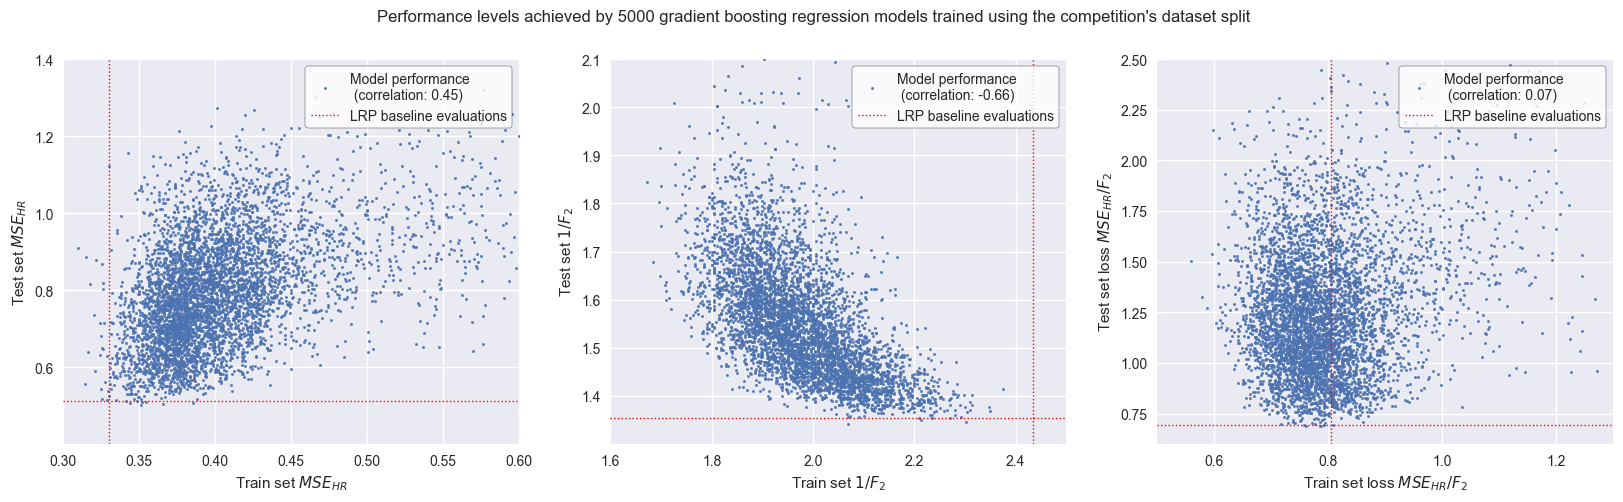

In [75]:
def plot_results(lgbmr_results, lrp_results):
    """
    Plot results according to the article

    Parameters:
    - lgbmr_results (pandas DataFrame) : Results of LGBMR
    - lrp_results (pandas DataFrame) : Results of LRP

    Returns: Visualisation
    """
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

    # Compute Spearman correlation for each metric
    mse_corr = round(spearmanr(lgbmr_results[['Train_MSE', 'Test_MSE']]).statistic, 2)
    f2_corr = round(spearmanr(lgbmr_results[['Train_1/F2', 'Test_1/F2']]).statistic, 2)
    loss_corr = round(spearmanr(lgbmr_results[['Train_Loss', 'Test_Loss']]).statistic, 2)
    
    # Generate first graph : MSE
    axs[0].scatter(lgbmr_results['Train_MSE'], lgbmr_results['Test_MSE'], s=3, label=f'Model performance \n (correlation: {mse_corr})')
    axs[0].axvline(x=lrp_results['Train_MSE'].loc[0], color='red', linestyle='dotted', linewidth=1.0)
    axs[0].axhline(y=lrp_results['Test_MSE'].loc[0], color='red', linestyle='dotted', linewidth=1.0, label='LRP baseline evaluations')
    axs[0].set_xlabel(r'Train set $MSE_{HR}$')
    axs[0].set_ylabel(r'Test set $MSE_{HR}$')
    axs[0].set_ylim(0.4, 1.4)
    axs[0].set_yticks(np.arange(0.6, 1.5, 0.2))
    axs[0].set_xlim(0.30, 0.60)
    axs[0].set_xticks(np.arange(0.30, 0.65, 0.05))
    axs[0].legend(loc='upper right', frameon=True, facecolor='white', edgecolor='black')
    
    # Generate second graph : 1/F2
    axs[1].scatter(lgbmr_results['Train_1/F2'], lgbmr_results['Test_1/F2'], s=3, label=f'Model performance \n (correlation: {f2_corr})')
    axs[1].axvline(x=1/lrp_results['Train_F2'].loc[0], color='red', linestyle='dotted', linewidth=1.0)
    axs[1].axhline(y=1/lrp_results['Test_F2'].loc[0], color='red', linestyle='dotted', linewidth=1.0, label='LRP baseline evaluations')
    axs[1].set_xlabel(r'Train set $1/F_{2}$')
    axs[1].set_ylabel(r'Test set $1/F_{2}$')
    axs[1].set_ylim(1.3, 2.1)
    axs[1].set_yticks(np.arange(1.4, 2.15, 0.1))
    axs[1].set_xlim(1.6, 2.5)
    axs[1].set_xticks(np.arange(1.6, 2.59, 0.2))
    axs[1].legend(loc='upper right', frameon=True, facecolor='white', edgecolor='black')

    # Generate third graph : Loss
    axs[2].scatter(lgbmr_results['Train_Loss'], lgbmr_results['Test_Loss'], s=3, label=f'Model performance \n (correlation: {loss_corr})')
    axs[2].axvline(x=lrp_results['Train_Loss'].loc[0], color='red', linestyle='dotted', linewidth=1.0)
    axs[2].axhline(y=lrp_results['Test_Loss'].loc[0], color='red', linestyle='dotted', linewidth=1.0, label='LRP baseline evaluations')
    axs[2].set_xlabel(r'Train set loss $MSE_{HR}/F_{2}$')
    axs[2].set_ylabel(r'Test set loss $MSE_{HR}/F_{2}$')
    axs[2].set_ylim(0.60, 2.5)
    axs[2].set_yticks(np.arange(0.75, 2.60, 0.25))
    axs[2].set_xlim(0.5, 1.3)
    axs[2].set_xticks(np.arange(0.6, 1.3, 0.2))
    axs[2].legend(loc='upper right', frameon=True, facecolor='white', edgecolor='black')

    plt.suptitle("Performance levels achieved by 5000 gradient boosting regression models trained using the competition's dataset split")

plot_results(lgbmr_results, lrp_results)

As expected, we obtain very similar results to those observed in the article, with the few differences being due to the random aspect of feature selection used by the model for training the trees. In our case, to have reproducible results, we have set the random seed for each trained model.

Consequently, as observed in the article, we notice a very low correlation between training testing dataset for the global loss and especially a highly negative correlation for the $F_2$ score. Basically, this is highly problematic because it means that even if our model improves on our training set, this does not translate to the test set, and even worse : it does the opposite. Two possibilities then emerge:
- Either our model systematically overfits on our training data, which leads to difficulty in generalizing to new data.
- Or the training data are not representative of the test data.

Following the reading of the article and particularly the remarks from different teams, it seems that the latter option prevails.

# Conclusion

In this notebook, we tackled the challenge posed by the ESA's "Collision Avoidance Challenge," aimed at predicting collision risks between spacecraft and debris. In this context, we attempted to reproduce and analyze the approaches and methods of the most successful teams in the competition based on the article *"Spacecraft Collision Avoidance Challenge: Design and Results of a Machine Learning Competition"* published by ESA.

Through this study, we understood that the main difficulty of this competition lay in the non-representativeness of the training set compared to the test set, undermining most machine learning techniques and making the LRP baseline particularly effective. This situation steered teams towards improving it rather than exploring more diverse approaches. In this regard, we will try to propose solutions to improve this representativeness in a future notebook project!